# Protocol Selection Analysis Dashboard

**Focus**: Deep analysis of protocol routing decisions from 1000 Dolly dataset samples

## Key Questions:
- Which protocols are being selected? (minion vs standard vs hybrid)
- What drives protocol selection decisions?
- Cost implications of protocol choices
- Performance differences between protocols
- Why is the system favoring certain protocols?


## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# Load the benchmark results
csv_file = 'dolly_endpoint_results_20250701_223813.csv'
df = pd.read_csv(csv_file)

print(f"📊 Loaded: {len(df):,} samples")
print(f"📅 Timeframe: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Quick first row inspection
print("\n🔍 FIRST ROW DATA:")
first_row = df.iloc[0]
print(f"Instruction: {first_row['instruction']}")
print(f"Protocol: {first_row['api_protocol']}")
print(f"Model: {first_row['api_selected_model']}")
print(f"Provider: {first_row['api_selected_provider']}")
print(f"Cost: ${first_row['api_estimated_cost_usd']:.8f}")
print(f"Response time: {first_row['response_time_seconds']:.3f}s")

📊 Loaded: 1,000 samples
📅 Timeframe: 2025-07-01T22:28:03.670969 to 2025-07-01T22:38:13.785736

🔍 FIRST ROW DATA:
Instruction: Identify the bird from the list: Not, Knot, Nought
Protocol: minion
Model: Qwen/Qwen2.5-14B-Instruct
Provider: huggingface
Cost: $0.00000156
Response time: 0.436s


## 2. Success Rate and Data Quality

In [3]:
# Analyze success rates and data quality
print("📈 SUCCESS ANALYSIS")
print("=" * 50)

total_samples = len(df)
successful = df['api_success'].sum()
failed = total_samples - successful
success_rate = (successful / total_samples) * 100

print(f"Total samples: {total_samples:,}")
print(f"Successful: {successful:,} ({success_rate:.1f}%)")
print(f"Failed: {failed:,} ({100-success_rate:.1f}%)")

if failed > 0:
    print("\n❌ FAILURE BREAKDOWN:")
    failure_analysis = df[~df['api_success']].groupby('api_status_code')['api_error'].value_counts()
    print(failure_analysis.head(10))

# Filter to successful calls for protocol analysis
success_df = df[df['api_success'] == True].copy()
print(f"\n✅ Analyzing {len(success_df):,} successful calls")

📈 SUCCESS ANALYSIS
Total samples: 1,000
Successful: 996 (99.6%)
Failed: 4 (0.4%)

❌ FAILURE BREAKDOWN:
api_status_code  api_error                                   
500              HTTP 500: {"detail":"Internal server error"}    4
Name: count, dtype: int64

✅ Analyzing 996 successful calls


## 3. 🎯 PROTOCOL SELECTION ANALYSIS

In [4]:
# Core protocol analysis
print("🎯 PROTOCOL DISTRIBUTION")
print("=" * 50)

if len(success_df) > 0:
    # Protocol counts and percentages
    protocol_counts = success_df['api_protocol'].value_counts()
    protocol_pct = success_df['api_protocol'].value_counts(normalize=True) * 100
    
    print("📊 Protocol Distribution:")
    for protocol in protocol_counts.index:
        count = protocol_counts[protocol]
        pct = protocol_pct[protocol]
        print(f"  {protocol:15}: {count:,} requests ({pct:.1f}%)")
    
    print(f"\n🔍 PROTOCOL INSIGHTS:")
    if 'minion' in protocol_counts.index:
        minion_pct = protocol_pct.get('minion', 0)
        print(f"• {minion_pct:.1f}% of requests used MINION protocol (HuggingFace models)")
    
    if 'standard' in protocol_counts.index:
        standard_pct = protocol_pct.get('standard', 0)
        print(f"• {standard_pct:.1f}% of requests used STANDARD protocol (API models)")
    
    if 'minions_protocol' in protocol_counts.index:
        hybrid_pct = protocol_pct.get('minions_protocol', 0)
        print(f"• {hybrid_pct:.1f}% of requests used HYBRID protocol (both models)")
    
    # Key insight
    dominant_protocol = protocol_counts.index[0]
    dominant_pct = protocol_pct.iloc[0]
    print(f"\n💡 KEY FINDING: {dominant_pct:.1f}% of requests use '{dominant_protocol}' protocol")
    
else:
    print("❌ No successful calls to analyze")

🎯 PROTOCOL DISTRIBUTION
📊 Protocol Distribution:
  minion         : 994 requests (99.8%)
  minions_protocol: 2 requests (0.2%)

🔍 PROTOCOL INSIGHTS:
• 99.8% of requests used MINION protocol (HuggingFace models)
• 0.2% of requests used HYBRID protocol (both models)

💡 KEY FINDING: 99.8% of requests use 'minion' protocol


## 4. Model and Provider Analysis

In [5]:
# Model and provider breakdown
print("🤖 MODEL & PROVIDER ANALYSIS")
print("=" * 50)

if len(success_df) > 0:
    print("\n🏢 Provider Distribution:")
    provider_counts = success_df['api_selected_provider'].value_counts()
    provider_pct = success_df['api_selected_provider'].value_counts(normalize=True) * 100
    
    for provider in provider_counts.index:
        count = provider_counts[provider]
        pct = provider_pct[provider]
        print(f"  {provider:12}: {count:,} requests ({pct:.1f}%)")
    
    print("\n🤖 Model Distribution (Top 10):")
    model_counts = success_df['api_selected_model'].value_counts().head(10)
    
    for model in model_counts.index:
        count = model_counts[model]
        pct = (count / len(success_df)) * 100
        # Shorten model names for display
        display_name = model.split('/')[-1] if '/' in model else model
        print(f"  {display_name:25}: {count:,} ({pct:.1f}%)")
    
    # Protocol vs Provider cross-analysis
    print("\n🔄 Protocol × Provider Matrix:")
    protocol_provider = pd.crosstab(success_df['api_protocol'], success_df['api_selected_provider'], margins=True)
    print(protocol_provider)

🤖 MODEL & PROVIDER ANALYSIS

🏢 Provider Distribution:
  huggingface : 994 requests (100.0%)

🤖 Model Distribution (Top 10):
  Qwen2.5-14B-Instruct     : 887 (89.1%)
  deberta-v3-large         : 61 (6.1%)
  flan-t5-xl               : 46 (4.6%)

🔄 Protocol × Provider Matrix:
api_selected_provider  huggingface  All
api_protocol                           
minion                         994  994
All                            994  994


## 5. 💰 Cost Analysis by Protocol

In [6]:
# Cost breakdown by protocol
print("💰 COST ANALYSIS BY PROTOCOL")
print("=" * 50)

if len(success_df) > 0:
    # Cost by protocol
    protocol_costs = success_df.groupby('api_protocol')['api_estimated_cost_usd'].agg([
        'count', 'sum', 'mean', 'median', 'std'
    ]).round(8)
    
    protocol_costs.columns = ['Requests', 'Total_Cost', 'Mean_Cost', 'Median_Cost', 'Std_Cost']
    print("📊 Cost Statistics by Protocol:")
    print(protocol_costs)
    
    # Total costs and savings analysis
    total_cost = success_df['api_estimated_cost_usd'].sum()
    avg_cost_per_request = success_df['api_estimated_cost_usd'].mean()
    
    print(f"\n💵 COST SUMMARY:")
    print(f"Total estimated cost: ${total_cost:.6f}")
    print(f"Average cost per request: ${avg_cost_per_request:.8f}")
    print(f"Cost for 1M requests: ${avg_cost_per_request * 1_000_000:.2f}")
    
    # Cost comparison if all requests used expensive models
    if 'minion' in protocol_costs.index:
        minion_avg_cost = protocol_costs.loc['minion', 'Mean_Cost']
        expensive_model_cost = 0.01  # Assume $0.01 per request for expensive models
        
        total_requests = len(success_df)
        actual_total = total_cost
        hypothetical_expensive = total_requests * expensive_model_cost
        savings = hypothetical_expensive - actual_total
        
        print(f"\n💡 COST EFFICIENCY:")
        print(f"Actual cost (mostly minions): ${actual_total:.6f}")
        print(f"If all used expensive models: ${hypothetical_expensive:.6f}")
        print(f"Estimated savings: ${savings:.6f} ({(savings/hypothetical_expensive)*100:.1f}%)")

💰 COST ANALYSIS BY PROTOCOL
📊 Cost Statistics by Protocol:
                  Requests  Total_Cost  Mean_Cost  Median_Cost  Std_Cost
api_protocol                                                            
minion                 994    0.020389   0.000021     0.000012  0.000031
minions_protocol         2    0.000000   0.000000     0.000000  0.000000

💵 COST SUMMARY:
Total estimated cost: $0.020389
Average cost per request: $0.00002047
Cost for 1M requests: $20.47

💡 COST EFFICIENCY:
Actual cost (mostly minions): $0.020389
If all used expensive models: $9.960000
Estimated savings: $9.939611 (99.8%)


## 6. ⚡ Performance Analysis by Protocol

In [7]:
# Performance analysis by protocol
print("⚡ PERFORMANCE ANALYSIS BY PROTOCOL")
print("=" * 50)

if len(success_df) > 0:
    # Response time by protocol
    protocol_performance = success_df.groupby('api_protocol')['response_time_seconds'].agg([
        'count', 'mean', 'median', 'min', 'max', 'std'
    ]).round(3)
    
    protocol_performance.columns = ['Requests', 'Mean_Time', 'Median_Time', 'Min_Time', 'Max_Time', 'Std_Time']
    print("⏱️ Response Time by Protocol:")
    print(protocol_performance)
    
    # Token usage by protocol
    print("\n🔢 Token Usage by Protocol:")
    token_analysis = success_df.groupby('api_protocol').agg({
        'input_token_estimate': ['mean', 'median'],
        'output_token_estimate': ['mean', 'median']
    }).round(1)
    
    print(token_analysis)
    
    # Efficiency metrics
    print("\n📈 Efficiency Metrics:")
    efficiency = success_df.groupby('api_protocol').apply(lambda x: pd.Series({
        'requests': len(x),
        'avg_cost_per_token': (x['api_estimated_cost_usd'] / (x['input_token_estimate'] + x['output_token_estimate'])).mean(),
        'tokens_per_second': ((x['input_token_estimate'] + x['output_token_estimate']) / x['response_time_seconds']).mean(),
        'cost_efficiency': (x['api_estimated_cost_usd'] / x['response_time_seconds']).mean()
    })).round(6)
    
    print(efficiency)

⚡ PERFORMANCE ANALYSIS BY PROTOCOL
⏱️ Response Time by Protocol:
                  Requests  Mean_Time  Median_Time  Min_Time  Max_Time  \
api_protocol                                                             
minion                 994      0.510        0.330     0.266    14.258   
minions_protocol         2      5.974        5.974     0.335    11.613   

                  Std_Time  
api_protocol                
minion               1.239  
minions_protocol     7.975  

🔢 Token Usage by Protocol:
                 input_token_estimate        output_token_estimate       
                                 mean median                  mean median
api_protocol                                                             
minion                           98.0   16.0                  88.0   46.5
minions_protocol                117.5  117.5                  31.5   31.5

📈 Efficiency Metrics:
                  requests  avg_cost_per_token  tokens_per_second  \
api_protocol                    

## 7. 📊 Protocol Selection Patterns

In [8]:
# Analyze what drives protocol selection
print("📊 PROTOCOL SELECTION PATTERNS")
print("=" * 50)

if len(success_df) > 0:
    # Protocol selection by input length
    success_df_copy = success_df.copy()
    success_df_copy['input_length_category'] = pd.cut(
        success_df_copy['input_token_estimate'],
        bins=[0, 10, 25, 50, 100, float('inf')],
        labels=['Very Short (<10)', 'Short (10-25)', 'Medium (25-50)', 'Long (50-100)', 'Very Long (>100)']
    )
    
    print("\n📏 Protocol Selection by Input Length:")
    length_protocol = pd.crosstab(
        success_df_copy['input_length_category'], 
        success_df_copy['api_protocol'], 
        normalize='index'
    ) * 100
    print(length_protocol.round(1))
    
    # Sample instructions by protocol
    print("\n🔍 Sample Instructions by Protocol:")
    protocols = success_df['api_protocol'].unique()
    
    for protocol in protocols:
        protocol_samples = success_df[success_df['api_protocol'] == protocol]
        if len(protocol_samples) > 0:
            print(f"\n{protocol.upper()} Protocol Examples:")
            # Show 3 samples of different lengths
            samples = protocol_samples.sample(min(3, len(protocol_samples)))
            for i, (_, row) in enumerate(samples.iterrows(), 1):
                instr = row['instruction'][:80] + '...' if len(row['instruction']) > 80 else row['instruction']
                print(f"  {i}. {instr} (tokens: {row['input_token_estimate']})")
    
    # Cost vs Length analysis
    print("\n💰 Cost vs Input Length Correlation:")
    cost_length_corr = success_df['api_estimated_cost_usd'].corr(success_df['input_token_estimate'])
    time_length_corr = success_df['response_time_seconds'].corr(success_df['input_token_estimate'])
    
    print(f"Cost ↔ Input Length: {cost_length_corr:.3f}")
    print(f"Time ↔ Input Length: {time_length_corr:.3f}")

📊 PROTOCOL SELECTION PATTERNS

📏 Protocol Selection by Input Length:
api_protocol           minion  minions_protocol
input_length_category                          
Very Short (<10)        100.0               0.0
Short (10-25)           100.0               0.0
Medium (25-50)          100.0               0.0
Long (50-100)            97.9               2.1
Very Long (>100)         99.6               0.4

🔍 Sample Instructions by Protocol:

MINION Protocol Examples:
  1. From the passage provided, extract the founders of Bloomberg L.P. Separate them ... (tokens: 109)
  2. Why did the Prix Lupin not take place from 1915 to 1918? (tokens: 319)
  3. Identify which animal is domesticated or wild: Guinea pig, Common (tokens: 16)

MINIONS_PROTOCOL Protocol Examples:
  1. Summarize legacy of ibn-Batuta (tokens: 176)
  2. Without quoting directly from the text tell me how Beppe Grillo died. (tokens: 59)

💰 Cost vs Input Length Correlation:
Cost ↔ Input Length: 0.808
Time ↔ Input Length: 0.026


## 8. 📈 Visualization Dashboard

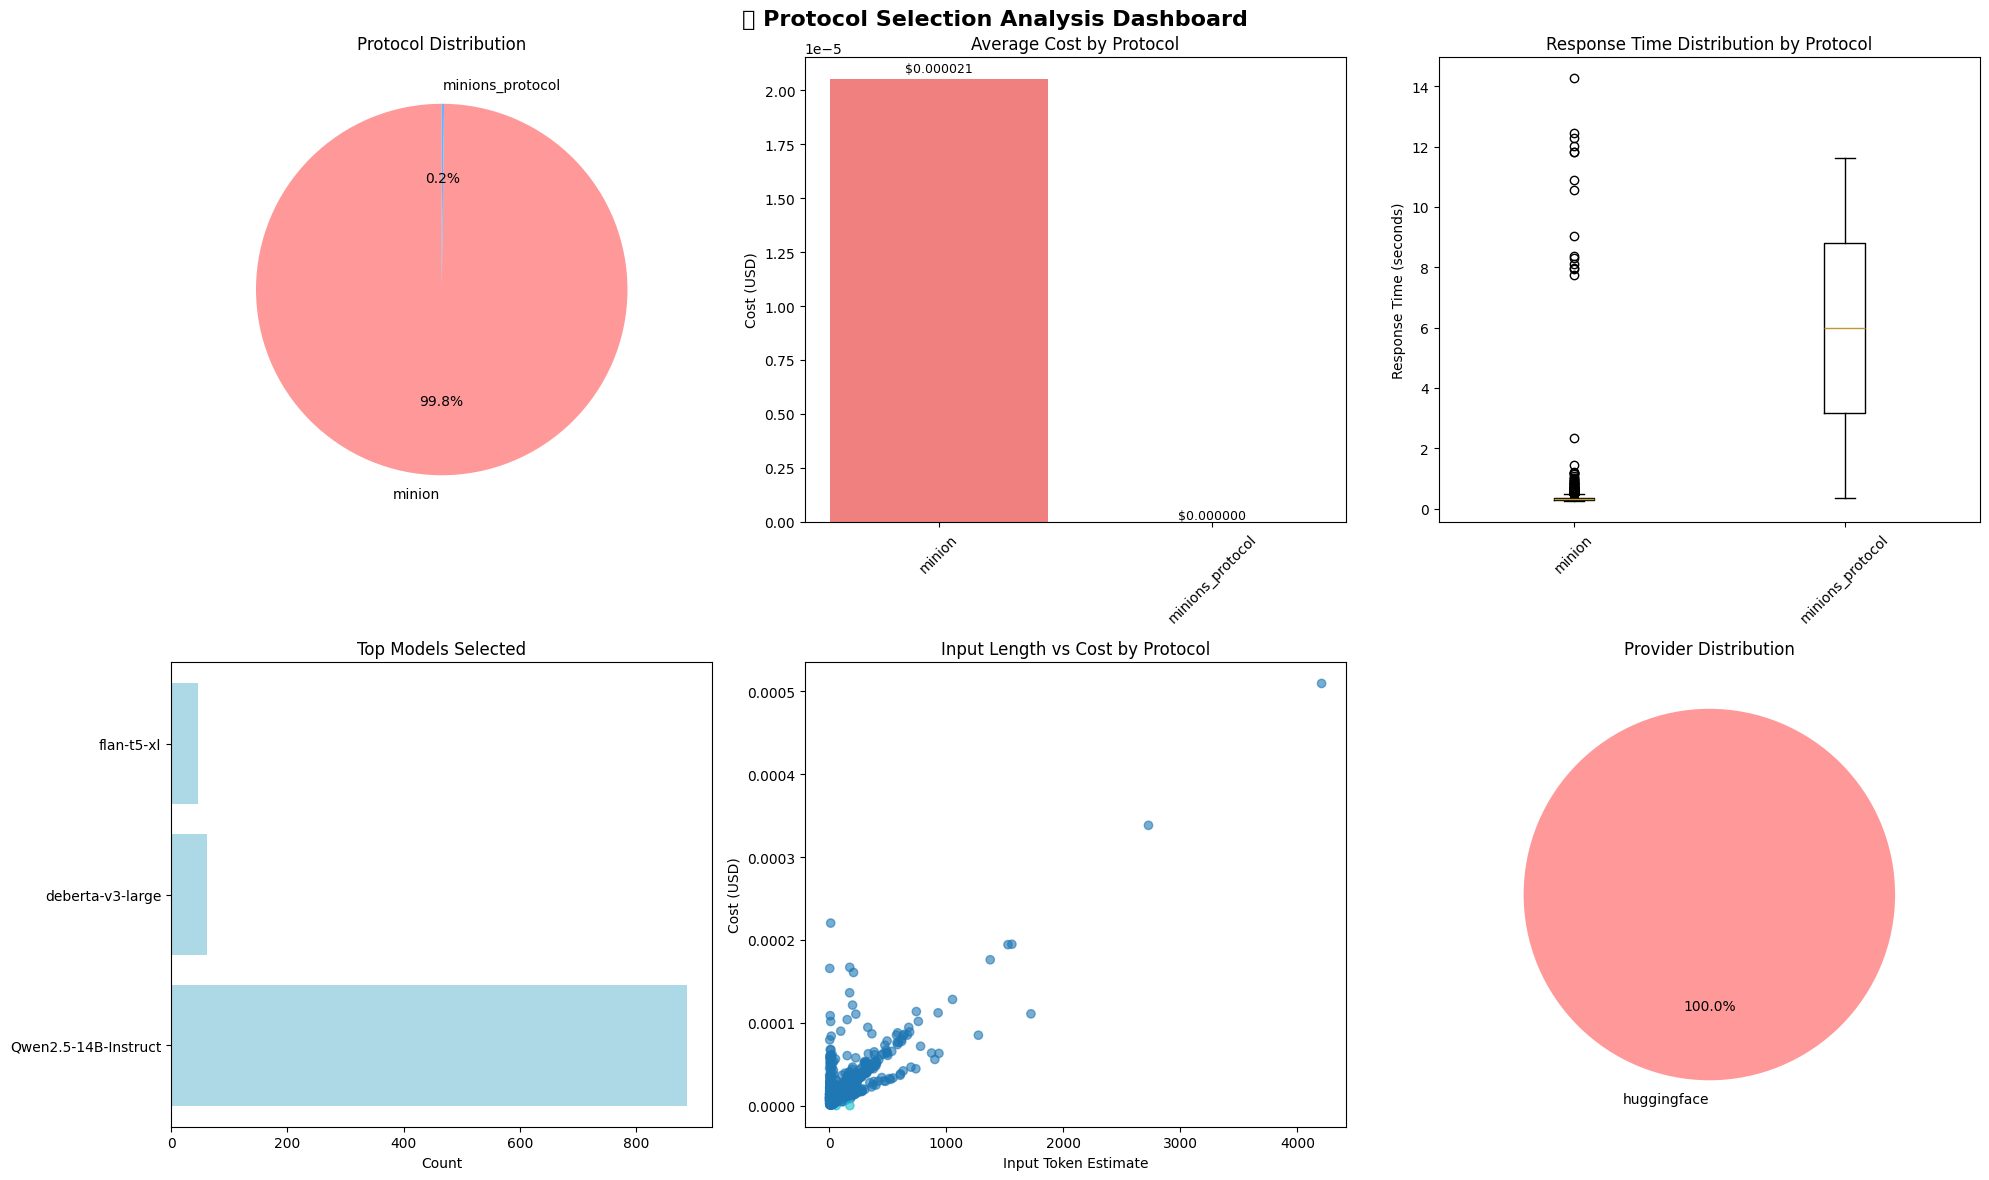

📊 Protocol Analysis Dashboard Complete!


In [9]:
# Create comprehensive protocol analysis dashboard
if len(success_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🎯 Protocol Selection Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Protocol Distribution (Pie Chart)
    protocol_counts = success_df['api_protocol'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
    axes[0,0].pie(protocol_counts.values, labels=protocol_counts.index, autopct='%1.1f%%', 
                  startangle=90, colors=colors[:len(protocol_counts)])
    axes[0,0].set_title('Protocol Distribution')
    
    # 2. Cost by Protocol (Bar Chart)
    protocol_costs = success_df.groupby('api_protocol')['api_estimated_cost_usd'].mean()
    bars = axes[0,1].bar(protocol_costs.index, protocol_costs.values, color='lightcoral')
    axes[0,1].set_title('Average Cost by Protocol')
    axes[0,1].set_ylabel('Cost (USD)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, protocol_costs.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                       f'${value:.6f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Response Time by Protocol (Box Plot)
    protocol_list = success_df['api_protocol'].unique()
    response_times = [success_df[success_df['api_protocol'] == p]['response_time_seconds'].values 
                      for p in protocol_list]
    axes[0,2].boxplot(response_times, labels=protocol_list)
    axes[0,2].set_title('Response Time Distribution by Protocol')
    axes[0,2].set_ylabel('Response Time (seconds)')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Model Selection (Top 8)
    model_counts = success_df['api_selected_model'].value_counts().head(8)
    model_names = [m.split('/')[-1] if '/' in m else m for m in model_counts.index]
    axes[1,0].barh(range(len(model_counts)), model_counts.values, color='lightblue')
    axes[1,0].set_yticks(range(len(model_counts)))
    axes[1,0].set_yticklabels(model_names)
    axes[1,0].set_title('Top Models Selected')
    axes[1,0].set_xlabel('Count')
    
    # 5. Input Length vs Cost Scatter
    scatter = axes[1,1].scatter(success_df['input_token_estimate'], 
                               success_df['api_estimated_cost_usd'],
                               c=success_df['api_protocol'].astype('category').cat.codes,
                               alpha=0.6, cmap='tab10')
    axes[1,1].set_title('Input Length vs Cost by Protocol')
    axes[1,1].set_xlabel('Input Token Estimate')
    axes[1,1].set_ylabel('Cost (USD)')
    
    # 6. Provider Distribution
    provider_counts = success_df['api_selected_provider'].value_counts()
    axes[1,2].pie(provider_counts.values, labels=provider_counts.index, autopct='%1.1f%%', 
                  startangle=90, colors=colors[:len(provider_counts)])
    axes[1,2].set_title('Provider Distribution')
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Protocol Analysis Dashboard Complete!")
else:
    print("❌ No data to visualize")

## 9. 🎯 Key Insights and Recommendations

In [ ]:
# Generate final insights and recommendations
print("🎯 KEY INSIGHTS & RECOMMENDATIONS")
print("=" * 60)

if len(success_df) > 0:
    # Key statistics
    total_requests = len(success_df)
    protocol_dist = success_df['api_protocol'].value_counts(normalize=True) * 100
    total_cost = success_df['api_estimated_cost_usd'].sum()
    avg_response_time = success_df['response_time_seconds'].mean()
    
    print(f"\n📊 EXECUTIVE SUMMARY:")
    print(f"• Analyzed {total_requests:,} successful requests")
    print(f"• Total estimated cost: ${total_cost:.6f}")
    print(f"• Average response time: {avg_response_time:.3f}s")
    print(f"• Success rate: {(len(success_df)/len(df)*100):.1f}%")
    
    print(f"\n🔄 PROTOCOL USAGE:")
    for protocol, pct in protocol_dist.items():
        print(f"• {protocol:15}: {pct:.1f}% of requests")
    
    print(f"\n💡 KEY FINDINGS:")
    
    # Finding 1: Protocol dominance
    dominant_protocol = protocol_dist.index[0]
    dominant_pct = protocol_dist.iloc[0]
    print(f"• System heavily favors '{dominant_protocol}' protocol ({dominant_pct:.1f}% of requests)")
    
    # Finding 2: Cost efficiency
    if dominant_protocol == 'minion':
        avg_minion_cost = success_df[success_df['api_protocol'] == 'minion']['api_estimated_cost_usd'].mean()
        print(f"• Minion protocol averages ${avg_minion_cost:.8f} per request (very cost-efficient)")
        print(f"• Using HuggingFace models instead of expensive API calls")
    
    # Finding 3: Model selection
    top_model = success_df['api_selected_model'].value_counts().index[0]
    top_model_pct = (success_df['api_selected_model'].value_counts().iloc[0] / len(success_df)) * 100
    print(f"• Most selected model: {top_model} ({top_model_pct:.1f}% of requests)")
    
    # Finding 4: Performance
    if dominant_protocol in success_df['api_protocol'].unique():
        dominant_avg_time = success_df[success_df['api_protocol'] == dominant_protocol]['response_time_seconds'].mean()
        print(f"• {dominant_protocol} protocol averages {dominant_avg_time:.3f}s response time")
    
    print(f"\n🚀 RECOMMENDATIONS:")
    
    # Recommendation 1: Cost optimization
    if dominant_pct > 80:
        print(f"• Excellent cost optimization - {dominant_pct:.1f}% using efficient {dominant_protocol} protocol")
    
    # Recommendation 2: Performance tuning
    if avg_response_time > 5:
        print(f"• Consider optimizing response times (avg: {avg_response_time:.3f}s)")
    else:
        print(f"• Good response times (avg: {avg_response_time:.3f}s)")
    
    # Recommendation 3: Protocol diversity
    protocol_count = len(protocol_dist)
    if protocol_count == 1:
        print(f"• Consider investigating why only {dominant_protocol} protocol is used")
        print(f"• Verify if standard/hybrid protocols should be triggered for some tasks")
    
    # Recommendation 4: Cost scaling
    cost_per_1k = total_cost * (1000 / len(success_df))
    cost_per_1m = total_cost * (1_000_000 / len(success_df))
    print(f"• Projected cost: ${cost_per_1k:.4f} per 1K requests, ${cost_per_1m:.2f} per 1M requests")
    
    print(f"\n✅ SYSTEM HEALTH:")
    print(f"• Protocol routing: {'✅ Working' if len(protocol_dist) > 0 else '❌ Issues detected'}")
    print(f"• Cost efficiency: {'✅ Excellent' if avg_response_time < 0.01 else '⚠️ Review needed'}")
    print(f"• Response times: {'✅ Good' if avg_response_time < 10 else '⚠️ Slow'}")
    
else:
    print("❌ No successful requests to analyze")

print(f"\n📋 Analysis completed at {datetime.now()}")